# 第11章  降维
  
  **降维的大致为特征选择和特征抽取，特征选择方面可以用统计方面的方法，例如相关性、互信息、卡方检验；特征抽取如PCA(主成份分析)，LDA（线性判别式分析）、多维标度法（MDS）。**


- 多余的特征会误导大多数学习器（例外是支持向量机就喜欢高维的空间）。
- 更多的特征就很有可能产生过拟合，如何避免过拟合又是一个新的问题。
- 数据的纬度可能虚高，真实的纬度可能很小，例如文本分词。
- 纬度少训练地越快速。
- 有利于可视化（二维、三维）。

### 11.2 选择特征

**通用的方法是筛选器（filter）和封装器（wrapper）**


##### 1、相关性
相关性，一般使用皮尔逊相关系数，即采`scipy.stat`中的`pearsonr()`函数


In [1]:
%matplotlib inline
import os

from matplotlib import pylab
import numpy as np
import scipy
from scipy.stats import norm, pearsonr  #导入皮尔逊相关系数

In [2]:
pearsonr([1,2,3], [1,2,3.1])

(0.99962228516121843, 0.017498096813278487)

In [3]:
pearsonr([1,2,3], [1,20,6])

(0.25383654128340477, 0.83661493668227427)

**皮尔逊相关系数`pearsonr()`返回一个元组，前面的值代表相关系数值，后面的值是`p`值，`p`值越高，越不能信任这个系数，即相关程度很低**

---

In [6]:
def _plot_correlation_func(x, y):

    r, p = pearsonr(x, y)
    title = "Cor($X_1$, $X_2$) = %.3f" % r
    pylab.scatter(x, y)
    pylab.title(title)
    pylab.xlabel("$X_1$")
    pylab.ylabel("$X_2$")

    f1 = scipy.poly1d(scipy.polyfit(x, y, 1))
    pylab.plot(x, f1(x), "r--", linewidth=2)
    # pylab.xticks([w*7*24 for w in [0,1,2,3,4]], ['week %i'%(w+1) for w in
    # [0,1,2,3,4]])


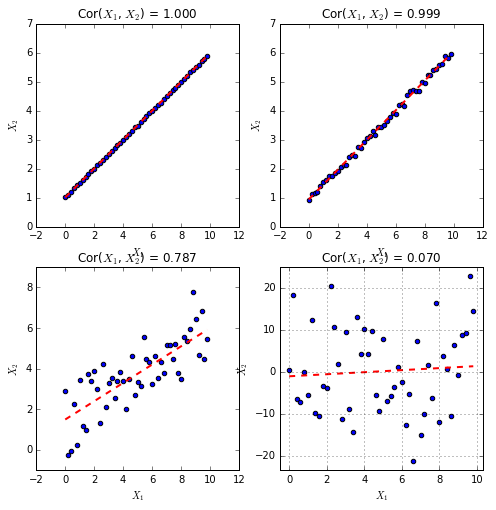

In [7]:
np.random.seed(0)  # to reproduce the data later on
pylab.clf()
pylab.figure(num=None, figsize=(8, 8))

x = np.arange(0, 10, 0.2)

pylab.subplot(221)
y = 0.5 * x + norm.rvs(1,  scale=.01, size=len(x))
_plot_correlation_func(x, y)

pylab.subplot(222)
y = 0.5 * x + norm.rvs(1,  scale=.1, size=len(x))
_plot_correlation_func(x, y)

pylab.subplot(223)
y = 0.5 * x + norm.rvs(1,  scale=1, size=len(x))
_plot_correlation_func(x, y)

pylab.subplot(224)
y = norm.rvs(1,  scale=10, size=len(x))
_plot_correlation_func(x, y)

pylab.autoscale(tight=True)
pylab.grid(True)

**上面的四幅图中，可以看出，$X_1$和$X_2$的相关程度，继而可以删除$X_1$或者$X_2$，而图四的相关程度很低，两者均可以保留**

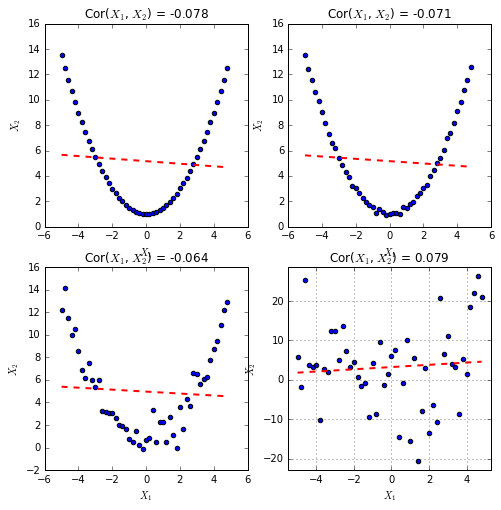

In [8]:
pylab.clf()
pylab.figure(num=None, figsize=(8, 8))

x = np.arange(-5, 5, 0.2)

pylab.subplot(221)
y = 0.5 * x ** 2 + norm.rvs(1,  scale=.01, size=len(x))
_plot_correlation_func(x, y)

pylab.subplot(222)
y = 0.5 * x ** 2 + norm.rvs(1,  scale=.1, size=len(x))
_plot_correlation_func(x, y)

pylab.subplot(223)
y = 0.5 * x ** 2 + norm.rvs(1,  scale=1, size=len(x))
_plot_correlation_func(x, y)

pylab.subplot(224)
y = 0.5 * x ** 2 + norm.rvs(1,  scale=10, size=len(x))
_plot_correlation_func(x, y)

pylab.autoscale(tight=True)
pylab.grid(True)

**从上面的图中可以看出，相关性的缺陷：相关性只能检验线性关系。对于非线性关系，我们使用<font color = red>互信息</font>**

---
##### 2、互信息
互信息计算两个特征所共有的信息，依赖数据的分布。而不确定性用**信息熵来表示**


In [12]:
scipy.stats.entropy([0.5,0.5],base = 2) #这个函数可以计算信息熵

1.0

In [13]:
scipy.stats.entropy([0.6,0.4],base = 2)

0.9709505944546688

In [14]:
from scipy.stats import norm, entropy

DATA_DIR = os.path.join("..", "data")
CHART_DIR = os.path.join("..", "charts")


def mutual_info(x, y, bins=10):
    counts_xy, bins_x, bins_y = np.histogram2d(x, y, bins=(bins, bins))
    counts_x, bins = np.histogram(x, bins=bins)
    counts_y, bins = np.histogram(y, bins=bins)

    counts_xy += 1
    counts_x += 1
    counts_y += 1
    P_xy = counts_xy / np.sum(counts_xy, dtype=float)
    P_x = counts_x / np.sum(counts_x, dtype=float)
    P_y = counts_y / np.sum(counts_y, dtype=float)

    I_xy = np.sum(P_xy * np.log2(P_xy / (P_x.reshape(-1, 1) * P_y)))

    return I_xy / (entropy(counts_x) + entropy(counts_y))


def plot_entropy():
    pylab.clf()
    pylab.figure(num=None, figsize=(5, 4))

    title = "Entropy $H(X)$"
    pylab.title(title)
    pylab.xlabel("$P(X=$coin will show heads up$)$")
    pylab.ylabel("$H(X)$")

    pylab.xlim(xmin=0, xmax=1.1)
    x = np.arange(0.001, 1, 0.001)
    y = -x * np.log2(x) - (1 - x) * np.log2(1 - x)
    pylab.plot(x, y)
    # pylab.xticks([w*7*24 for w in [0,1,2,3,4]], ['week %i'%(w+1) for w in
    # [0,1,2,3,4]])

    pylab.autoscale(tight=True)
    pylab.grid(True)

    filename = "entropy_demo.png"
    pylab.savefig(os.path.join(CHART_DIR, filename), bbox_inches="tight")


def _plot_mi_func(x, y):

    mi = mutual_info(x, y)
    title = "NI($X_1$, $X_2$) = %.3f" % mi
    pylab.scatter(x, y)
    pylab.title(title)
    pylab.xlabel("$X_1$")
    pylab.ylabel("$X_2$")

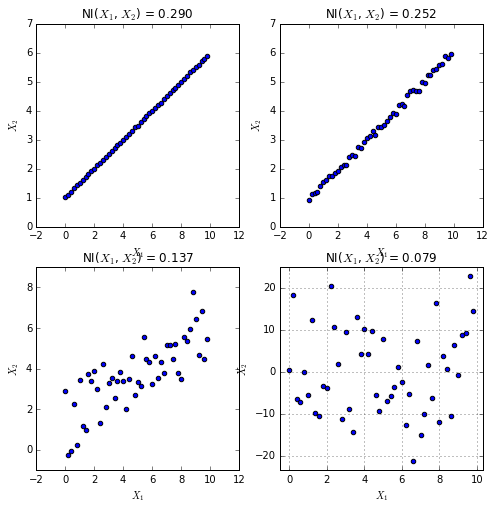

In [16]:
np.random.seed(0)  # to reproduce the data later on
pylab.clf()
pylab.figure(num=None, figsize=(8, 8))

x = np.arange(0, 10, 0.2)

pylab.subplot(221)
y = 0.5 * x + norm.rvs(1, scale=.01, size=len(x))
_plot_mi_func(x, y)

pylab.subplot(222)
y = 0.5 * x + norm.rvs(1, scale=.1, size=len(x))
_plot_mi_func(x, y)

pylab.subplot(223)
y = 0.5 * x + norm.rvs(1, scale=1, size=len(x))
_plot_mi_func(x, y)

pylab.subplot(224)
y = norm.rvs(1, scale=10, size=len(x))
_plot_mi_func(x, y)

pylab.autoscale(tight=True)
pylab.grid(True)

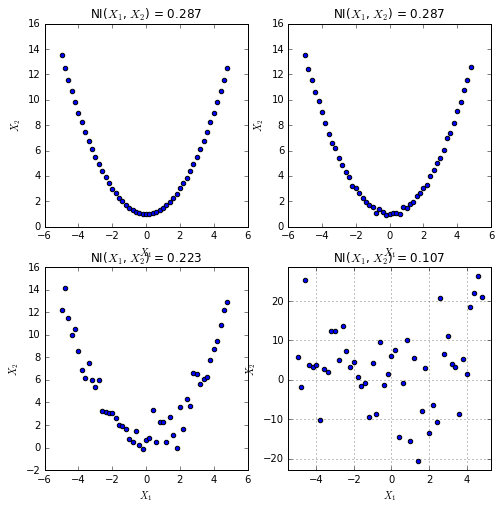

In [17]:
pylab.clf()
pylab.figure(num=None, figsize=(8, 8))

x = np.arange(-5, 5, 0.2)

pylab.subplot(221)
y = 0.5 * x ** 2 + norm.rvs(1, scale=.01, size=len(x))
_plot_mi_func(x, y)

pylab.subplot(222)
y = 0.5 * x ** 2 + norm.rvs(1, scale=.1, size=len(x))
_plot_mi_func(x, y)

pylab.subplot(223)
y = 0.5 * x ** 2 + norm.rvs(1, scale=1, size=len(x))
_plot_mi_func(x, y)

pylab.subplot(224)
y = 0.5 * x ** 2 + norm.rvs(1, scale=10, size=len(x))
_plot_mi_func(x, y)

pylab.autoscale(tight=True)
pylab.grid(True)


**对互信息较高的特征对，会丢掉其中的一个特征， 在进行回归的时候，可以把互信息非常低的信息丢掉**

---

##### 筛选器的缺点
对特征较多时，计算量会很大。筛选器丢掉了独立使用时没有用处的变量，但是这些独立的变量，在进行组合时，会有用。要保留这些特征就需要用到封装器了。

#### 封装器（wrapper） 选择特征

在**scikit-learn**中，在`sklearn.feature_selection`包里面有很多优秀的分装器类，其中**RFE （recursive feature elimination）**，他会把一个估算器和预期数量的特征当作参数，然后只要发现足够小的特征子集，然后就在这个特征集合里训练估算器。**RFE**实例在封装估算器的同时，它本身也是一个估算器。 

**一个例子：**    
通过`datasets`和`make_classification`创建一个人工构造的分类问题。包含100个样本，10个特征，其中只有3个特征对解决分类问题有帮助。

In [18]:
from sklearn.feature_selection import RFE  # 加载RFE
from sklearn.linear_model import LogisticRegression  # 加载逻辑回归

from sklearn.datasets import make_classification  # make_classfiction是人工构造的分类

X, y = make_classification(
    n_samples=100, n_features=10, n_informative=3, random_state=0)

clf = LogisticRegression()  # 创建人工分类实例
clf.fit(X, y)  # 拟合

for i in range(1, 11):
    selector = RFE(clf, i)
    selector = selector.fit(X, y)
    print("%i\t%s\t%s" % (i, selector.support_, selector.ranking_))


1	[False False False False  True False False False False False]	[ 9  3  6  2  1  5  4 10  8  7]
2	[False False False  True  True False False False False False]	[8 2 5 1 1 4 3 9 7 6]
3	[False  True False  True  True False False False False False]	[7 1 4 1 1 3 2 8 6 5]
4	[False  True False  True  True False  True False False False]	[6 1 3 1 1 2 1 7 5 4]
5	[False  True False  True  True  True  True False False False]	[5 1 2 1 1 1 1 6 4 3]
6	[False  True  True  True  True  True  True False False False]	[4 1 1 1 1 1 1 5 3 2]
7	[False  True  True  True  True  True  True False False  True]	[3 1 1 1 1 1 1 4 2 1]
8	[False  True  True  True  True  True  True False  True  True]	[2 1 1 1 1 1 1 3 1 1]
9	[ True  True  True  True  True  True  True False  True  True]	[1 1 1 1 1 1 1 2 1 1]
10	[ True  True  True  True  True  True  True  True  True  True]	[1 1 1 1 1 1 1 1 1 1]


**一些特征的选择方法 是嵌套在学习过程中的。例如决策树、随机森林、xgboost**
<br>
<br>
**另外一些是 使用正则化的方法对模型进行惩罚，将效用不大的特征的重要性将为0，然后抛弃（L1正则化），**

### 11.3 特征抽取

- 线性：PCA
- 非线性：MDS

##### PCA
- 保守方差最大
- 重构误差最小

**基本步骤：**
- （1）从数据中减去均值
- （2）计算协方差矩阵
- （3）计算协方差矩阵的特征向量


In [19]:
from sklearn import linear_model, decomposition
from sklearn import lda

logistic = linear_model.LogisticRegression()


CHART_DIR = os.path.join("..", "charts")

np.random.seed(3)

x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(loc=0, scale=1, size=len(x1))


C:\Users\markXU\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


[ 0.96393127]


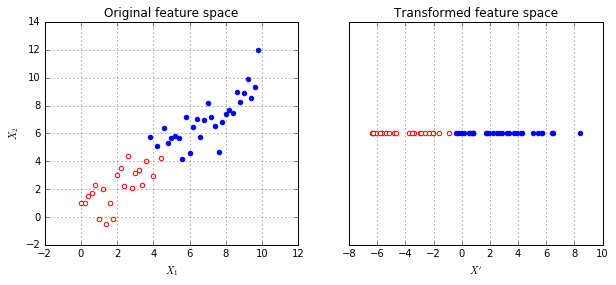

In [20]:
pylab.clf()
fig = pylab.figure(num=None, figsize=(10, 4))
pylab.subplot(121)

title = "Original feature space"
pylab.title(title)
pylab.xlabel("$X_1$")
pylab.ylabel("$X_2$")

x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(loc=0, scale=1, size=len(x1))

good = (x1 > 5) | (x2 > 5)
bad = ~good

x1g = x1[good]
x2g = x2[good]
pylab.scatter(x1g, x2g, edgecolor="blue", facecolor="blue")

x1b = x1[bad]
x2b = x2[bad]
pylab.scatter(x1b, x2b, edgecolor="red", facecolor="white")

pylab.grid(True)

pylab.subplot(122)

X = np.c_[(x1, x2)]

pca = decomposition.PCA(n_components=1)
Xtrans = pca.fit_transform(X)

Xg = Xtrans[good]
Xb = Xtrans[bad]

pylab.scatter(
    Xg[:, 0], np.zeros(len(Xg)), edgecolor="blue", facecolor="blue")
pylab.scatter(
    Xb[:, 0], np.zeros(len(Xb)), edgecolor="red", facecolor="white")
title = "Transformed feature space"
pylab.title(title)
pylab.xlabel("$X'$")
fig.axes[1].get_yaxis().set_visible(False)

print(pca.explained_variance_ratio_)

pylab.grid(True)


**实际情况下，我们不会知道 `n_components` 的值 ，而是让它完全转换，对数据进行拟合。`explained_variance_ratio_`会包含一个降序排列的数组。


[ 0.98318496]


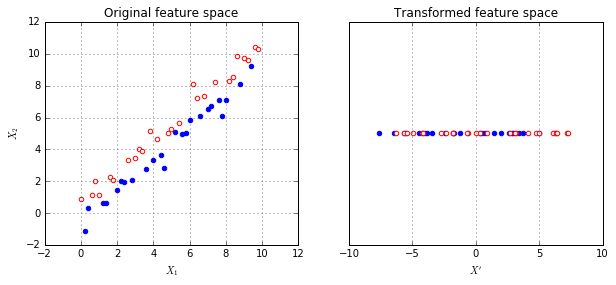

In [21]:
pylab.clf()
fig = pylab.figure(num=None, figsize=(10, 4))
pylab.subplot(121)

title = "Original feature space"
pylab.title(title)
pylab.xlabel("$X_1$")
pylab.ylabel("$X_2$")

x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(loc=0, scale=1, size=len(x1))

good = x1 > x2
bad = ~good

x1g = x1[good]
x2g = x2[good]
pylab.scatter(x1g, x2g, edgecolor="blue", facecolor="blue")

x1b = x1[bad]
x2b = x2[bad]
pylab.scatter(x1b, x2b, edgecolor="red", facecolor="white")

pylab.grid(True)

pylab.subplot(122)

X = np.c_[(x1, x2)]

pca = decomposition.PCA(n_components=1)
Xtrans = pca.fit_transform(X)

Xg = Xtrans[good]
Xb = Xtrans[bad]

pylab.scatter(
    Xg[:, 0], np.zeros(len(Xg)), edgecolor="blue", facecolor="blue")
pylab.scatter(
    Xb[:, 0], np.zeros(len(Xb)), edgecolor="red", facecolor="white")
title = "Transformed feature space"
pylab.title(title)
pylab.xlabel("$X'$")
fig.axes[1].get_yaxis().set_visible(False)

print(pca.explained_variance_ratio_)

pylab.grid(True)

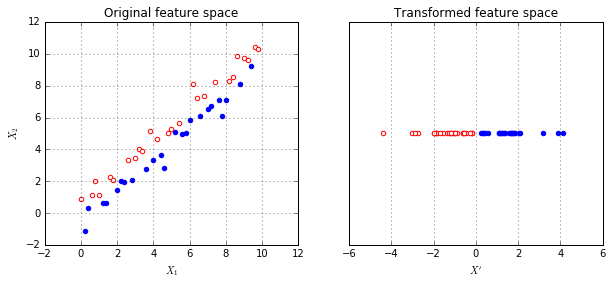

In [24]:
pylab.clf()
fig = pylab.figure(num=None, figsize=(10, 4))
pylab.subplot(121)

title = "Original feature space"
pylab.title(title)
pylab.xlabel("$X_1$")
pylab.ylabel("$X_2$")

good = x1 > x2
bad = ~good

x1g = x1[good]
x2g = x2[good]
pylab.scatter(x1g, x2g, edgecolor="blue", facecolor="blue")

x1b = x1[bad]
x2b = x2[bad]
pylab.scatter(x1b, x2b, edgecolor="red", facecolor="white")

pylab.grid(True)

pylab.subplot(122)

X = np.c_[(x1, x2)]

lda_inst = lda.LDA(n_components=1)
Xtrans = lda_inst.fit_transform(X, good)

Xg = Xtrans[good]
Xb = Xtrans[bad]

pylab.scatter(
    Xg[:, 0], np.zeros(len(Xg)), edgecolor="blue", facecolor="blue")
pylab.scatter(
    Xb[:, 0], np.zeros(len(Xb)), edgecolor="red", facecolor="white")
title = "Transformed feature space"
pylab.title(title)
pylab.xlabel("$X'$")
fig.axes[1].get_yaxis().set_visible(False)

pylab.grid(True)


**线性判别式分析（LDA）：让不同类别样本之间的距离最大，同种样本之间的样本距离最小。PCA是一种无监督的特征抽取方法，LDA是有监督的方法。**

---
### 11.4 多维标度法（MDS）
**MDS**对样本数据之间的不相似性感兴趣，并把不相似性解释为距离。


In [26]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn import linear_model, manifold, decomposition, datasets
logistic = linear_model.LogisticRegression()


CHART_DIR = os.path.join("..", "charts")

np.random.seed(3)

# all examples will have three classes in this file
colors = ['r', 'g', 'b']
markers = ['o', 6, '*']


def plot_demo_1():
    X = np.c_[np.ones(5), 2 * np.ones(5), 10 * np.ones(5)].T
    y = np.array([0, 1, 2])

    fig = pylab.figure(figsize=(10, 4))

    ax = fig.add_subplot(121, projection='3d')
    ax.set_axis_bgcolor('white')

    mds = manifold.MDS(n_components=3)
    Xtrans = mds.fit_transform(X)

    for cl, color, marker in zip(np.unique(y), colors, markers):
        ax.scatter(
            Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], Xtrans[y == cl][:, 2], c=color, marker=marker, edgecolor='black')
    pylab.title("MDS on example data set in 3 dimensions")
    ax.view_init(10, -15)

    mds = manifold.MDS(n_components=2)
    Xtrans = mds.fit_transform(X)

    ax = fig.add_subplot(122)
    for cl, color, marker in zip(np.unique(y), colors, markers):
        ax.scatter(
            Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], c=color, marker=marker, edgecolor='black')
    pylab.title("MDS on example data set in 2 dimensions")


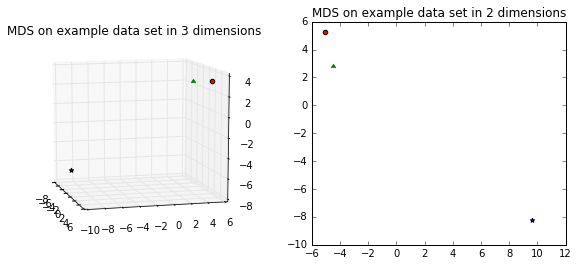

In [27]:
plot_demo_1()

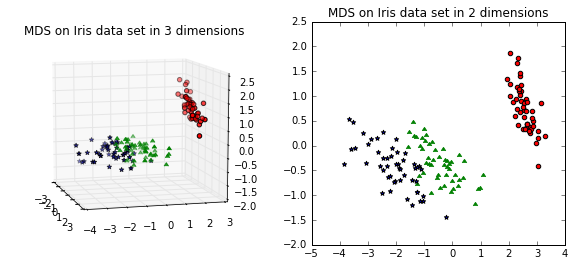

In [32]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

# MDS

fig = pylab.figure(figsize=(10, 4))

ax = fig.add_subplot(121, projection='3d')
ax.set_axis_bgcolor('white')

mds = manifold.MDS(n_components=3)
Xtrans = mds.fit_transform(X)

for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(
        Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], Xtrans[y == cl][:, 2], c=color, marker=marker, edgecolor='black')
pylab.title("MDS on Iris data set in 3 dimensions")
ax.view_init(10, -15)

mds = manifold.MDS(n_components=2)
Xtrans = mds.fit_transform(X)

ax = fig.add_subplot(122)
for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(
        Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], c=color, marker=marker, edgecolor='black')
pylab.title("MDS on Iris data set in 2 dimensions")

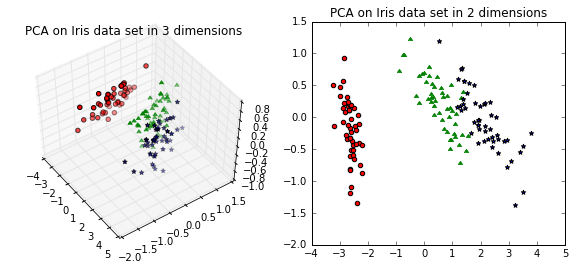

In [33]:
# PCA

fig = pylab.figure(figsize=(10, 4))

ax = fig.add_subplot(121, projection='3d')
ax.set_axis_bgcolor('white')

pca = decomposition.PCA(n_components=3)
Xtrans = pca.fit(X).transform(X)

for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(
        Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], Xtrans[y == cl][:, 2], c=color, marker=marker, edgecolor='black')
pylab.title("PCA on Iris data set in 3 dimensions")
ax.view_init(50, -35)

pca = decomposition.PCA(n_components=2)
Xtrans = pca.fit_transform(X)

ax = fig.add_subplot(122)
for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(
        Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], c=color, marker=marker, edgecolor='black')
pylab.title("PCA on Iris data set in 2 dimensions")